In [1]:
import mlflow
from mlflow.tracking.client import MlflowClient
import re

In [2]:
mlflow.set_tracking_uri('file:///home/akira/akira/p-poteka-analysis/mlruns')

In [3]:
exprs = mlflow.get_experiment("9")
exprs.name

'important_feats_minmax'

In [4]:
eval_runs = MlflowClient().search_runs("9", filter_string="tags.mlflow.project.entryPoint = 'evaluate'")
eval_runs[0]

<Run: data=<RunData: metrics={'All_sample_RMSE': 6.265229370738512,
 'NOT_TC_case_2019-10-04_4-0_start': 10.252543077478657,
 'NOT_TC_case_2019-10-04_5-0_start': 7.541760954597825,
 'NOT_TC_case_2019-10-04_6-0_start': 3.0695739117994862,
 'NOT_TC_case_2019-10-04_7-0_start': 0.6923503715872744,
 'NOT_TC_case_2019-10-12_10-0_start': 4.4569506641000896,
 'NOT_TC_case_2019-10-12_8-0_start': 19.05025387115761,
 'NOT_TC_case_2019-10-12_9-0_start': 14.858999715847482,
 'NOT_TC_case_2020-07-04_10-0_start': 0.45088384582311486,
 'NOT_TC_case_2020-07-04_6-0_start': 7.012391363605118,
 'NOT_TC_case_2020-07-04_7-0_start': 14.81689342056437,
 'NOT_TC_case_2020-07-04_8-0_start': 13.892786749485024,
 'NOT_TC_case_2020-07-04_9-0_start': 4.175149650738355,
 'One_Hour_Prediction_RMSE': 2.5139145282734816,
 'Sequential_NOT_TC_case_2019-10-04_4-0_start': 2.589850760751083,
 'Sequential_NOT_TC_case_2019-10-04_5-0_start': 1.3067205771191739,
 'Sequential_NOT_TC_case_2019-10-04_6-0_start': 0.3709824793706571

In [5]:
len(eval_runs)

14

In [6]:
# One value metric pattern
all_sample_rmse_pattern = "All_sample_RMSE"
ten_minutes_prediction_rmse_pattern = "One_Hour_Prediction_RMSE"

# Mluitple vlayues metric pattern 
## TC case
tc_case_regex = "^TC_case_.+"
seq_tc_case_regex = "^Sequential_TC_case_.+"

## NOT TC case
not_tc_case_regex = "^NOT_TC_case_.+"
seq_not_tc_case_regex = "^Sequential_NOT_TC_case_.+"

# R2 score
r2_regex = "^r2_.+"

In [7]:
from typing import Dict, List

all_sample_rmse: Dict[str, float] = {}
ten_minutes_prediction_rmse: Dict[str, float] = {}

tc_case_rmses: Dict[str, list] = {}
seq_tc_case_rmses: Dict[str, list] = {}

not_tc_case_rmses: Dict[str, list] = {}
seq_not_tc_case_rmses: Dict[str, list] = {}

r2_scores: Dict[str, float] = {}

def get_metrics_list(mlflow_metrics_history: List[mlflow.entities.Metric]) -> Dict:
    res = {}
    for metric in mlflow_metrics_history:
        res[str(metric.step)] = metric.value
    return res
        
for run in eval_runs:
    metrics_key = run.data.tags["mlflow.runName"].replace("_evaluation", "")
    
    tc_case_rmses[metrics_key] = {}
    seq_tc_case_rmses[metrics_key] = {}
    
    not_tc_case_rmses[metrics_key] = {}
    seq_not_tc_case_rmses[metrics_key] = {}
    
    r2_scores[metrics_key] = {}
    
    # Get Metrics
    metrics: Dict[str, float] = run.data.metrics
    for key, val in metrics.items():
        if key == all_sample_rmse_pattern:
            all_sample_rmse[metrics_key] = val
        elif key == ten_minutes_prediction_rmse_pattern:
            ten_minutes_prediction_rmse[metrics_key] = val
        
        elif re.match(tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
        elif re.match(seq_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            seq_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
        
        elif re.match(not_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            not_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
            
        elif re.match(seq_not_tc_case_regex, key) is not None:
            metrics_history = MlflowClient().get_metric_history(run.info.run_id, key)
            seq_not_tc_case_rmses[metrics_key][key] = get_metrics_list(metrics_history)
            
        if re.match(r2_regex, key) is not None:
            r2_scores[metrics_key][key] = val

In [8]:
# Validate metrics
from unittest import TestCase

test_mod = TestCase()

parameter_pattern_counts = 14
test_case_counts = 12

test_mod.assertEqual(len(all_sample_rmse), parameter_pattern_counts)
test_mod.assertEqual(len(ten_minutes_prediction_rmse), parameter_pattern_counts)

test_mod.assertEqual(len(tc_case_rmses), parameter_pattern_counts)
for metrics_history in [tc_case_rmses[i] for i in tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(seq_tc_case_rmses), parameter_pattern_counts)
for metrics_histotry in [seq_tc_case_rmses[i] for i in seq_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(not_tc_case_rmses), parameter_pattern_counts)
for metrics_history in [not_tc_case_rmses[i] for i in not_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(seq_not_tc_case_rmses), parameter_pattern_counts)
for metrics_history in [seq_not_tc_case_rmses[i] for i in seq_not_tc_case_rmses.keys()]:
    with test_mod.subTest(metrics_history=metrics_history):
        test_mod.assertEqual(len(metrics_history), test_case_counts)
        
test_mod.assertEqual(len(r2_scores), parameter_pattern_counts)

In [9]:
# Visualze result
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

all_sample_rmse_df = pd.DataFrame({"tag": all_sample_rmse.keys(), "value": all_sample_rmse.values()})
all_sample_rmse_df = all_sample_rmse_df.set_index("tag")
print(all_sample_rmse_df.sort_values("value", ascending=True))

                                        value
tag                                          
RainTemperatureHumidity              6.010363
RainTemperatureWindAbs_wind          6.129466
RainHumidityWind                     6.146291
RainTemperature                      6.177595
Rain                                 6.205380
RainHumidityWindAbs_wind             6.215797
RainWind                             6.265229
RainHumidity                         6.271965
RainHumidityAbs_wind                 6.273967
RainTemperatureWind                  6.342637
RainTemperatureHumidityWindAbs_wind  6.364856
RainTemperatureHumidityWind          6.389170
RainTemperatureHumidityAbs_wind      6.486370
RainTemperatureAbs_wind              6.486490


In [10]:
ten_minutes_prediction_rmse_df = pd.DataFrame({"tag": ten_minutes_prediction_rmse.keys(), "value": ten_minutes_prediction_rmse.values()})
ten_minutes_prediction_rmse_df = ten_minutes_prediction_rmse_df.set_index("tag")
print(ten_minutes_prediction_rmse_df.sort_values("value", ascending=True))

                                        value
tag                                          
RainHumidity                         2.274900
RainTemperature                      2.414298
RainTemperatureHumidityAbs_wind      2.423402
RainTemperatureWindAbs_wind          2.441712
RainTemperatureAbs_wind              2.446537
RainTemperatureHumidityWind          2.457255
RainTemperatureWind                  2.479100
RainTemperatureHumidity              2.491406
RainWind                             2.513915
RainTemperatureHumidityWindAbs_wind  2.526557
RainHumidityWind                     2.550716
RainHumidityWindAbs_wind             2.572536
Rain                                 2.582797
RainHumidityAbs_wind                 2.754669


<AxesSubplot:xlabel='all prediction', ylabel='ten minutes prediction'>

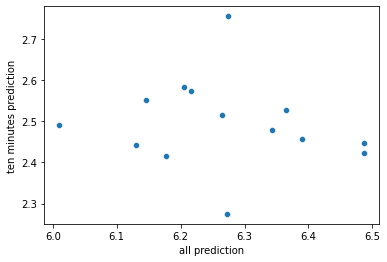

In [11]:
df = pd.concat([all_sample_rmse_df, ten_minutes_prediction_rmse_df], axis=1)
df.columns = ["all prediction", "ten minutes prediction"]
sns.scatterplot(data=df, x="all prediction", y="ten minutes prediction")

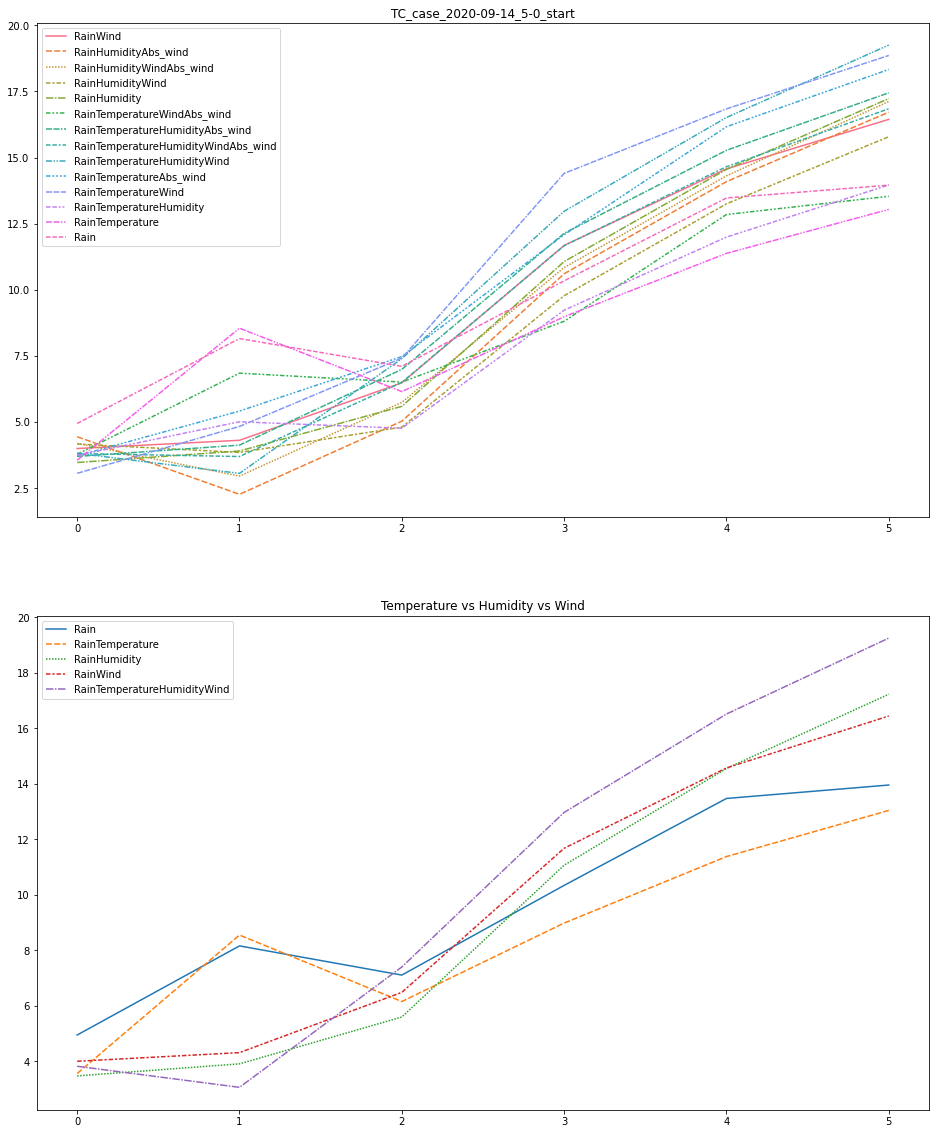

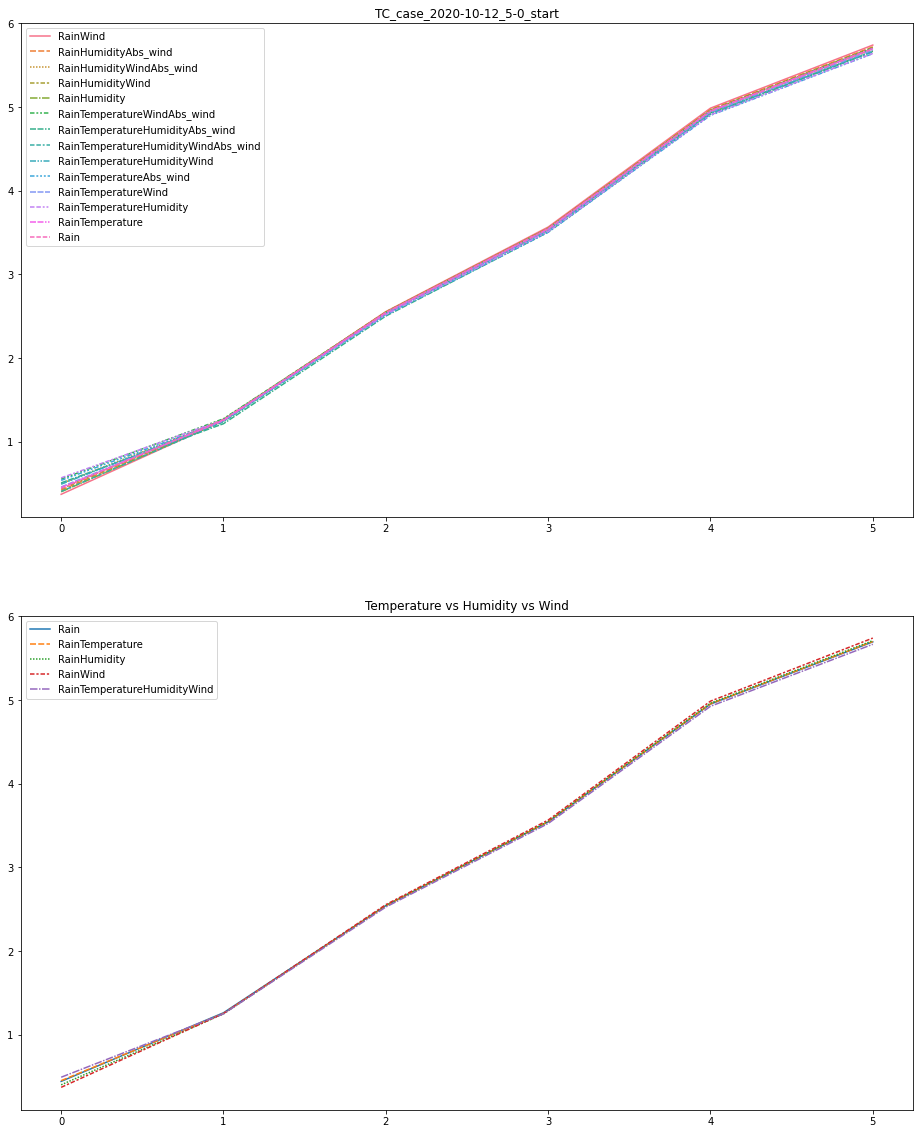

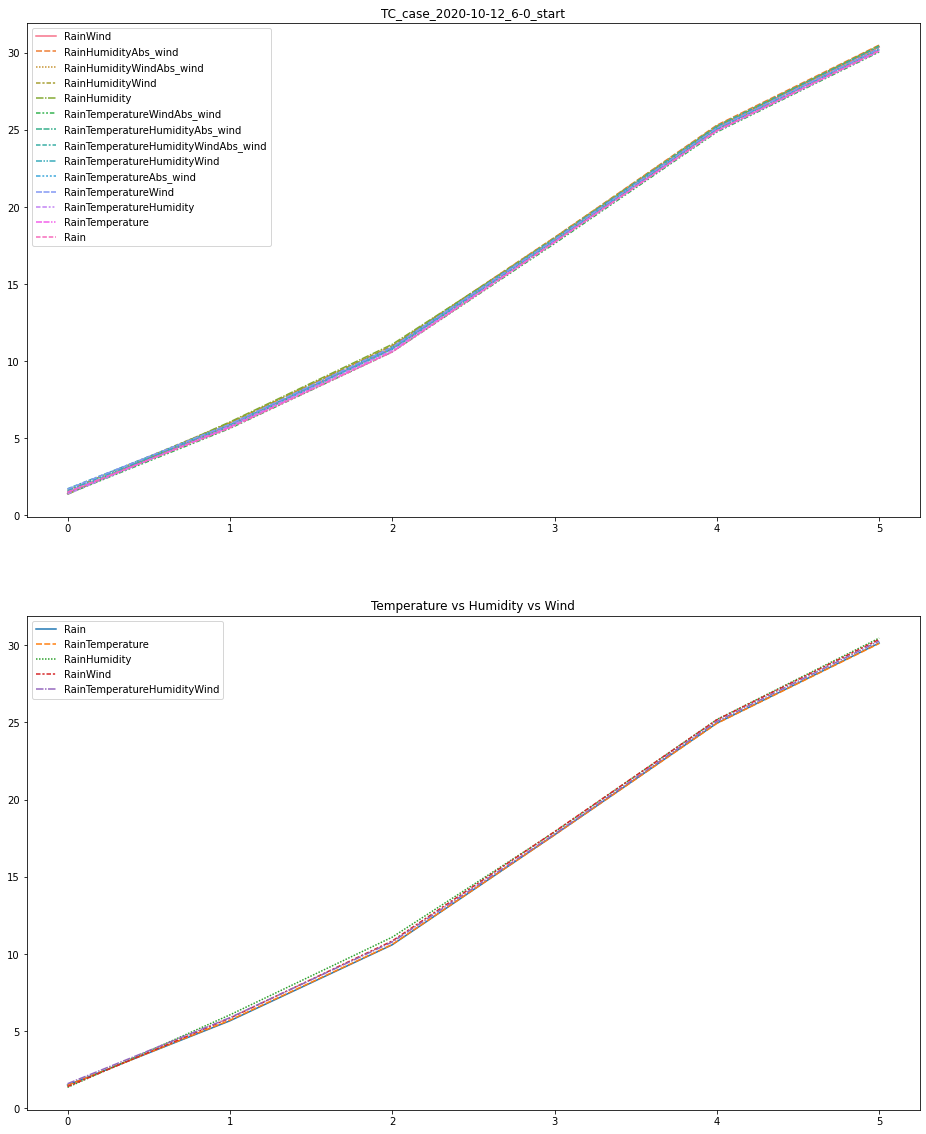

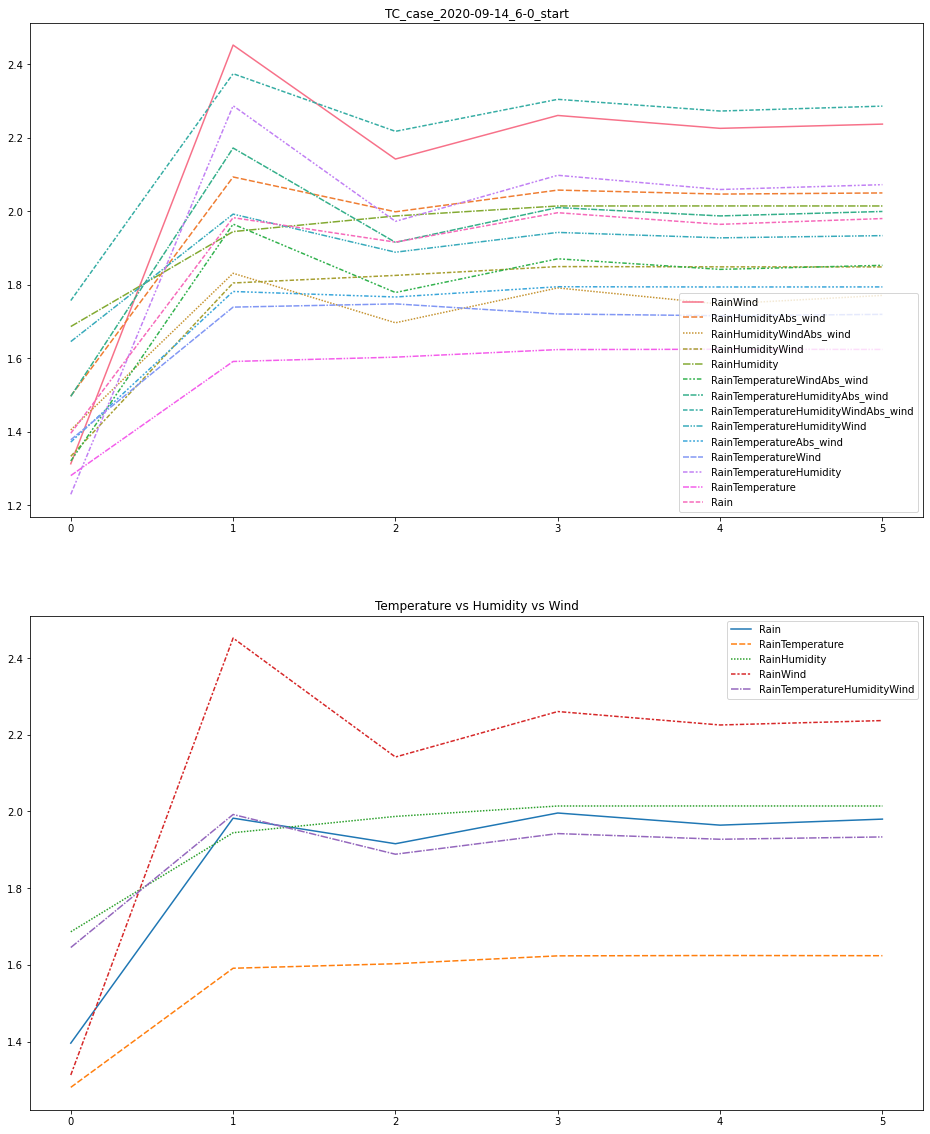

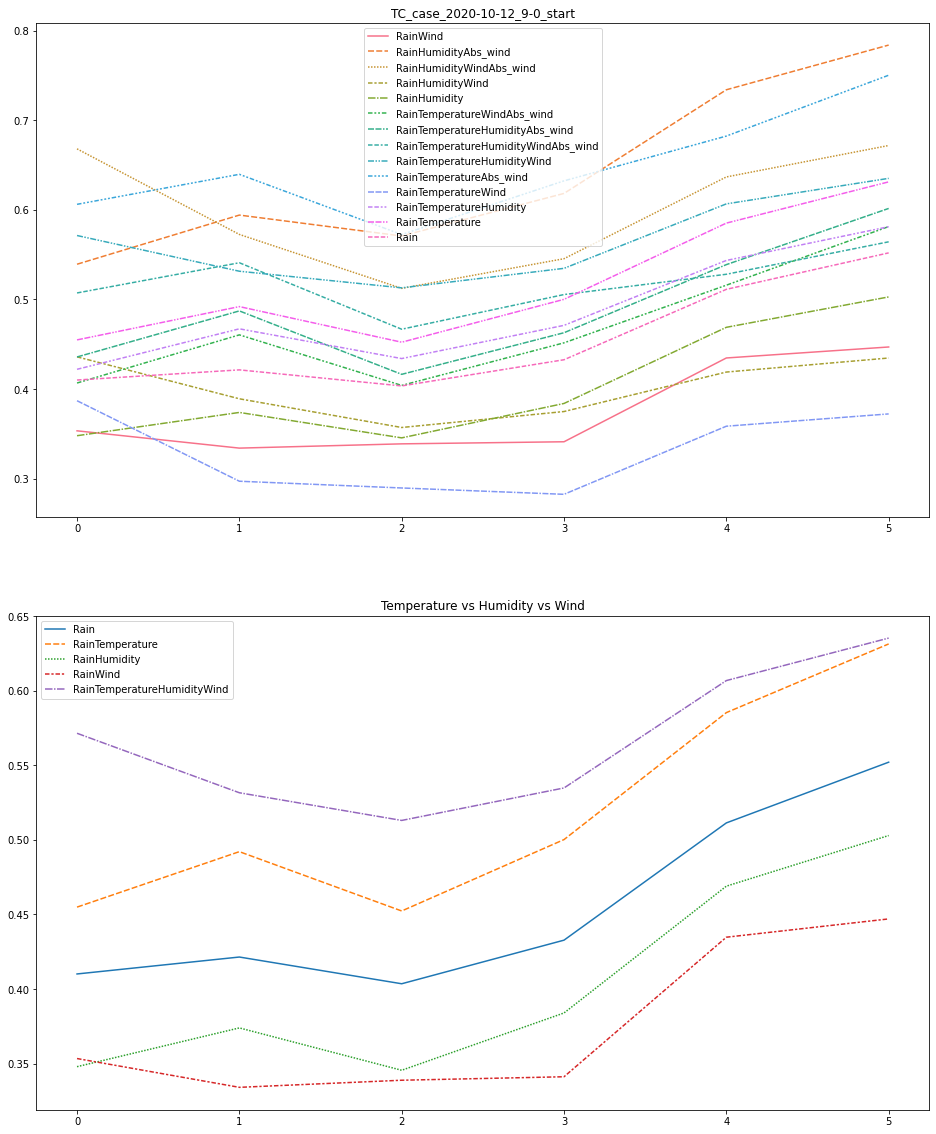

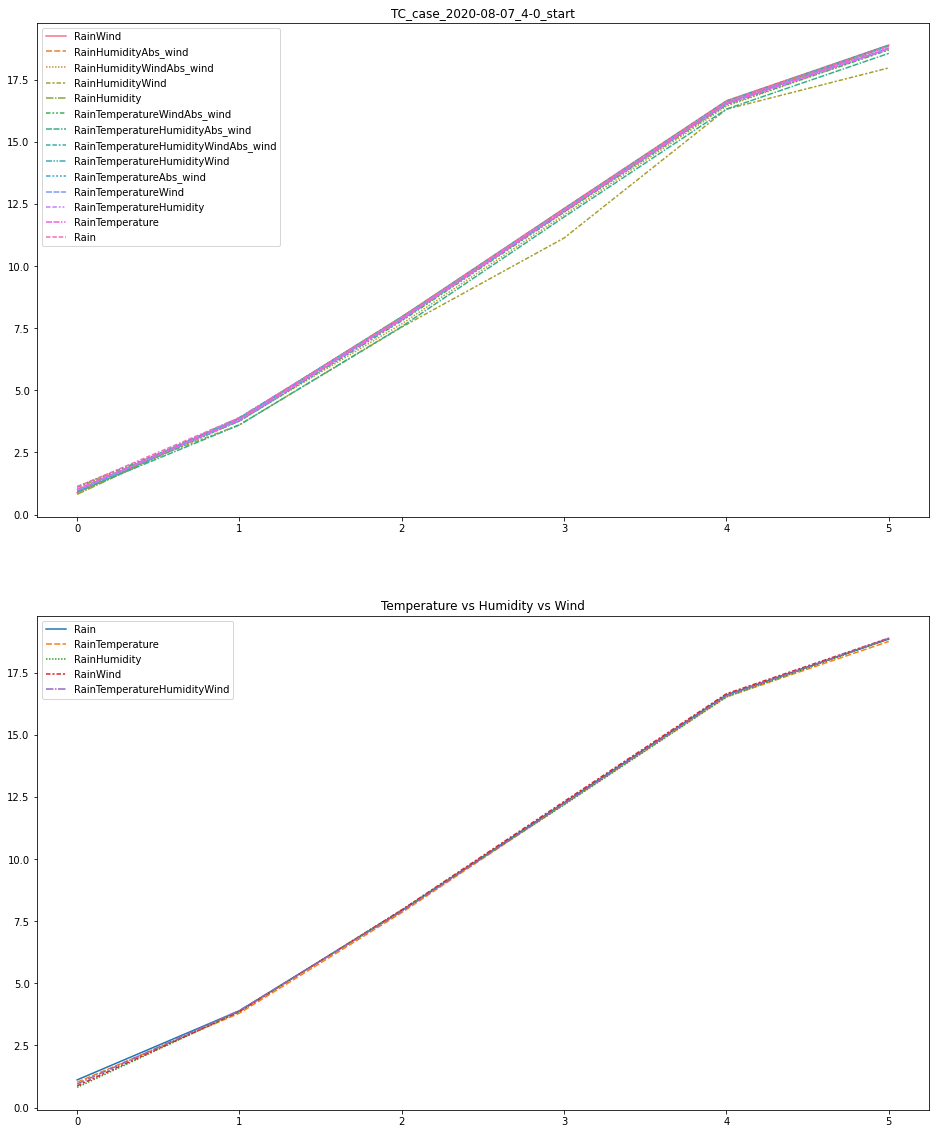

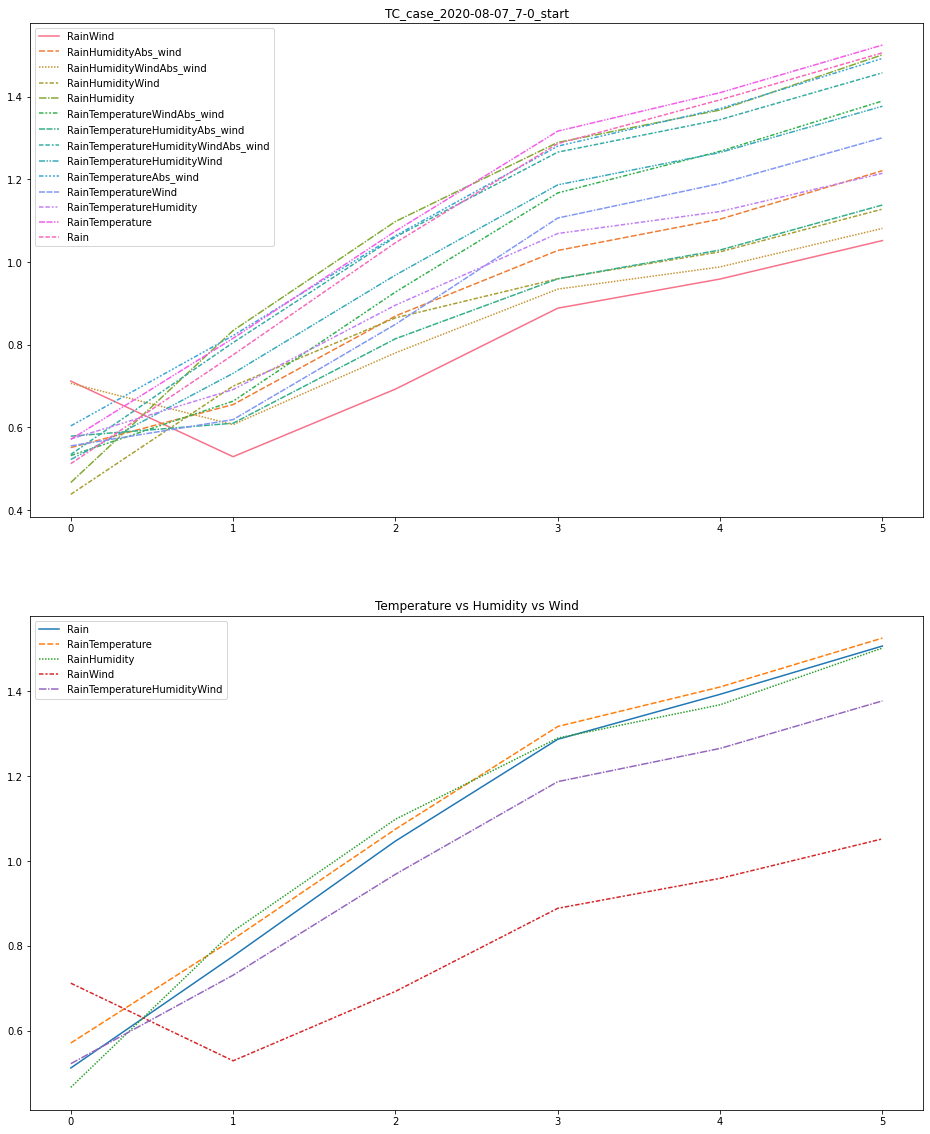

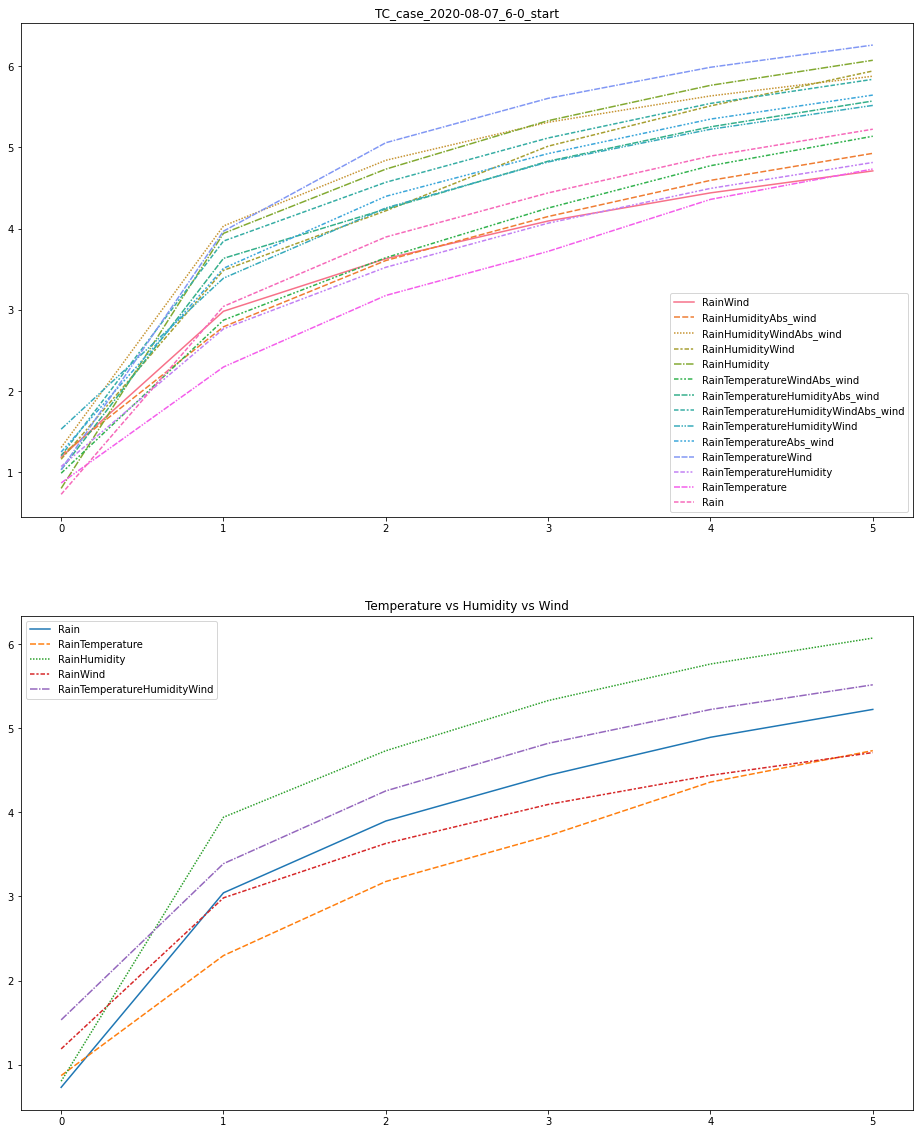

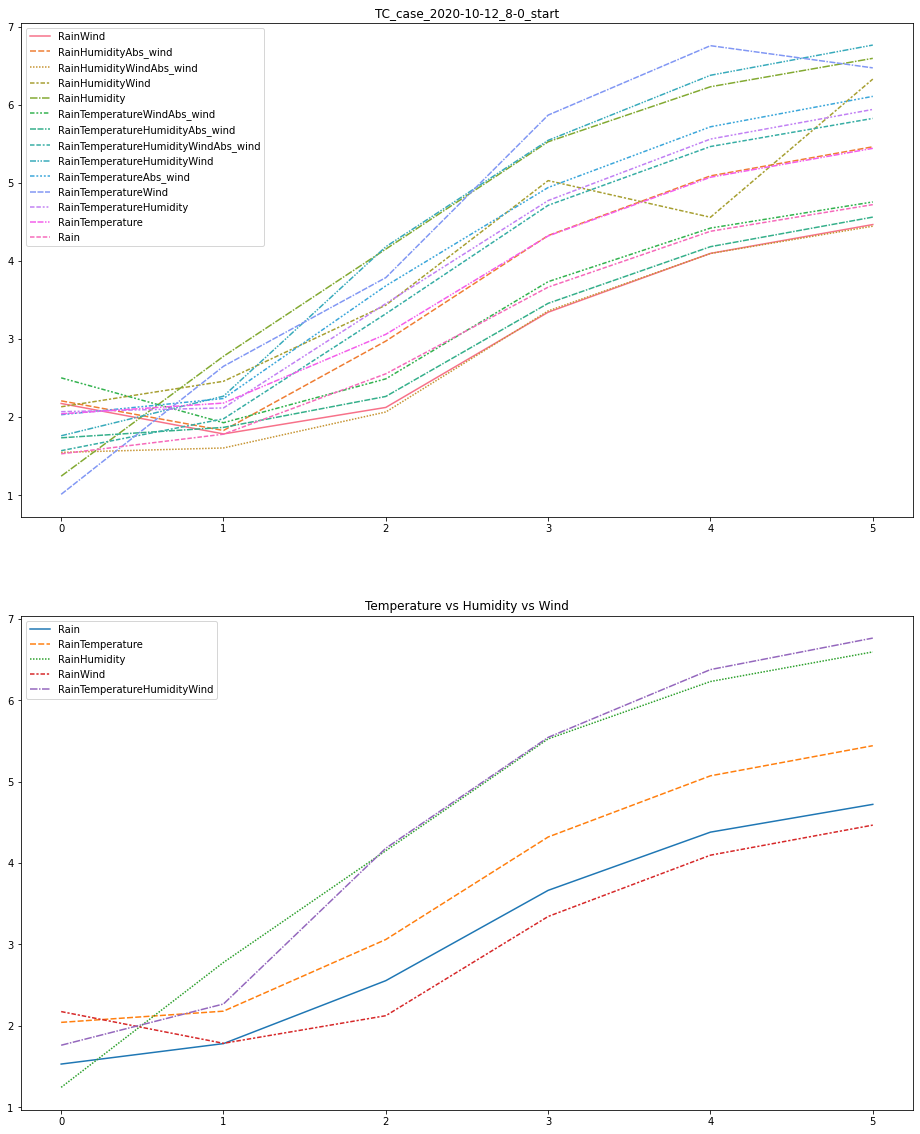

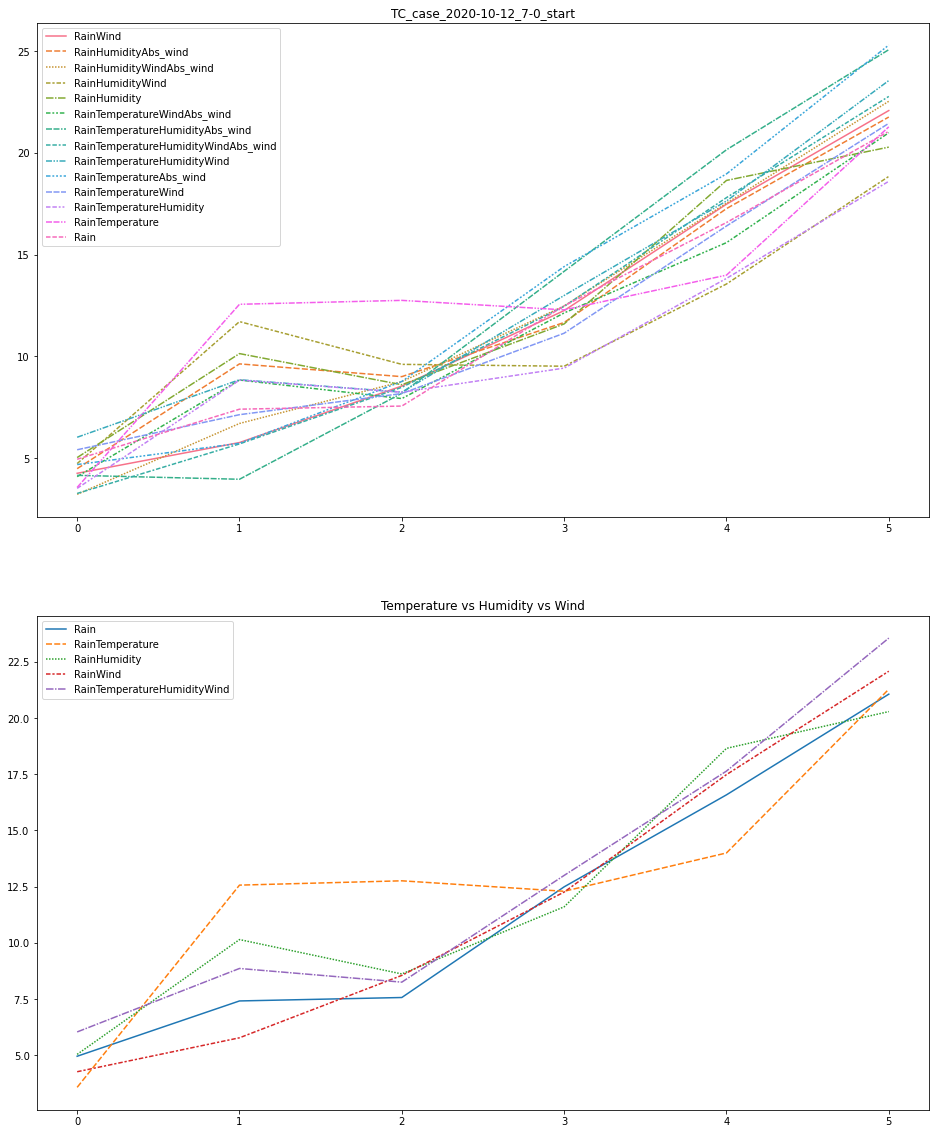

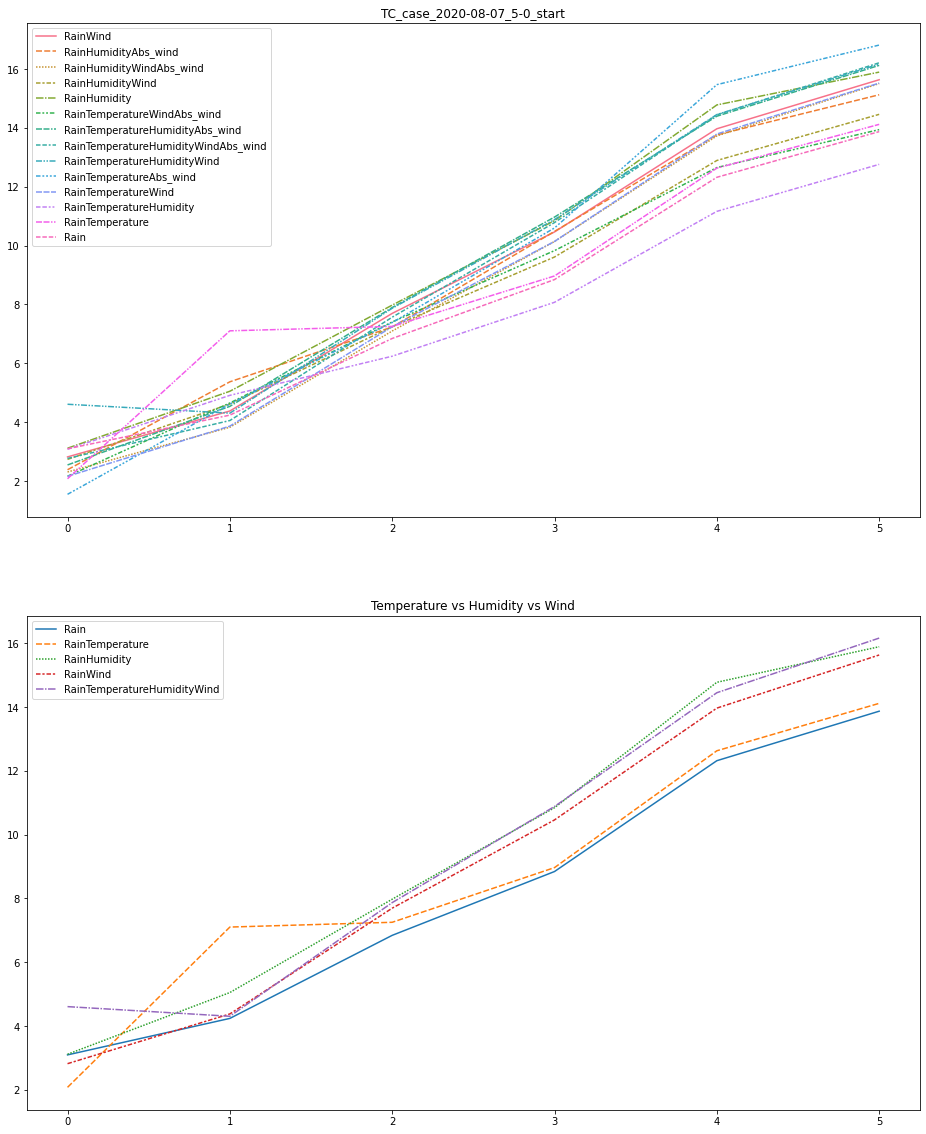

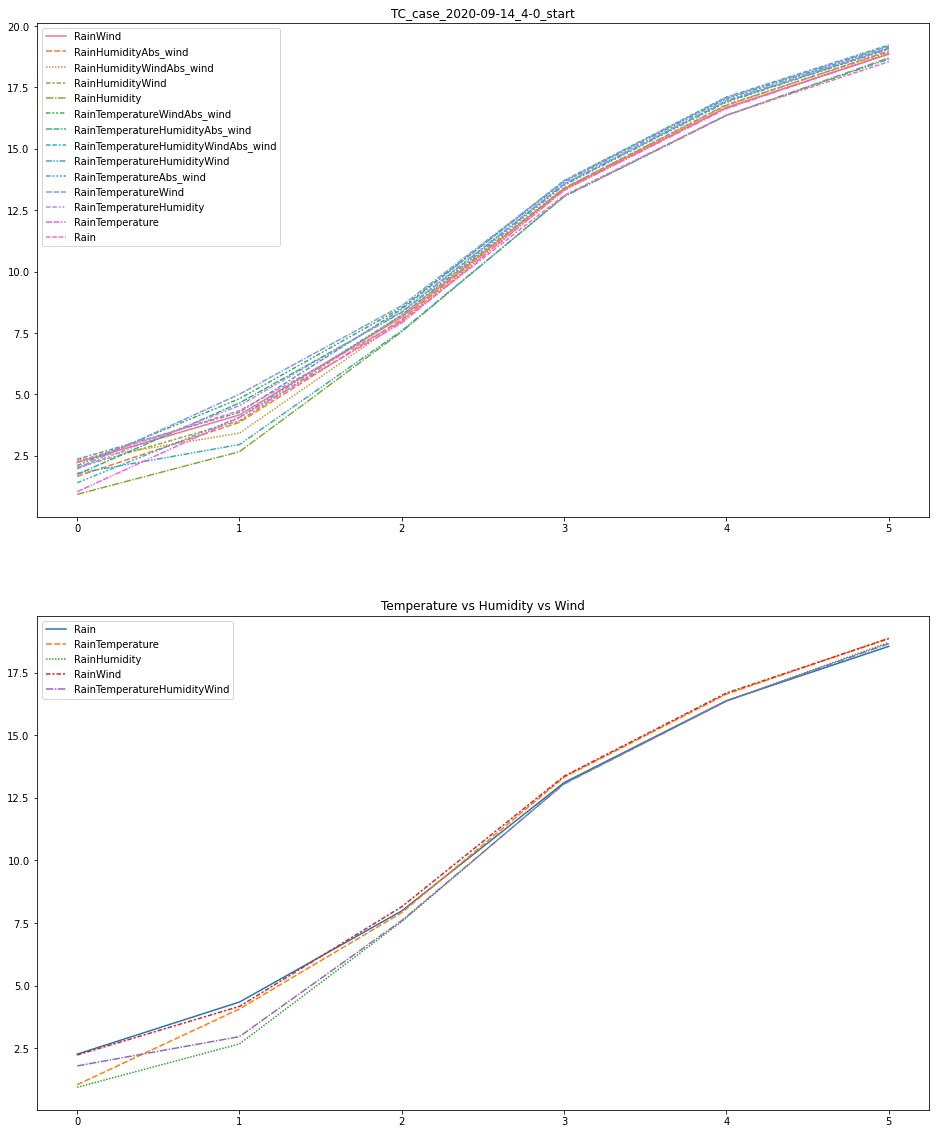

In [27]:
# TC case result

case_names = list(tc_case_rmses["Rain"].keys())
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    # Visualize
    fig, ax = plt.subplots(2, 1, figsize=(16, 20))
    ax = ax.flatten()
    # Compare with all input parameters
    sns.lineplot(data=df, ax=ax[0])
    ax[0].set_title(case_name)
    
    # Select target parameters
    target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
    sns.lineplot(data=df[target_cols], ax=ax[1])
    ax[1].set_title("Temperature vs Humidity vs Wind")
    
    plt.savefig(f"./minmax_img/{case_name}.png")
#     # Compare with temperature
#     ## Temperature
#     hue_columns = [i for i in df.columns if "Temperature" in i]
#     other_columns = [i for i in df.columns if "Temperature" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="blue")
#     ax[1].set_title("It includes temperature (orange) or not (blue)")
#     ## Humidity
#     hue_columns = [i for i in df.columns if "Humidity" in i]
#     other_columns = [i for i in df.columns if "Humidity" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="blue")
#     ax[2].set_title("It includes humidity (orange) or not (blue)")
    
#     ## Wind (Wind & Abs_wind)
#     hue_columns = [i for i in df.columns if "Wind" in i or "Abs_wind" in i]
#     other_columns = [i for i in df.columns if "Wind" not in i or "Abs_wind" in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="blue")
#     ax[3].set_title("It includes wind (orange) or not (blue)")
    
    plt.show()
    plt.close()

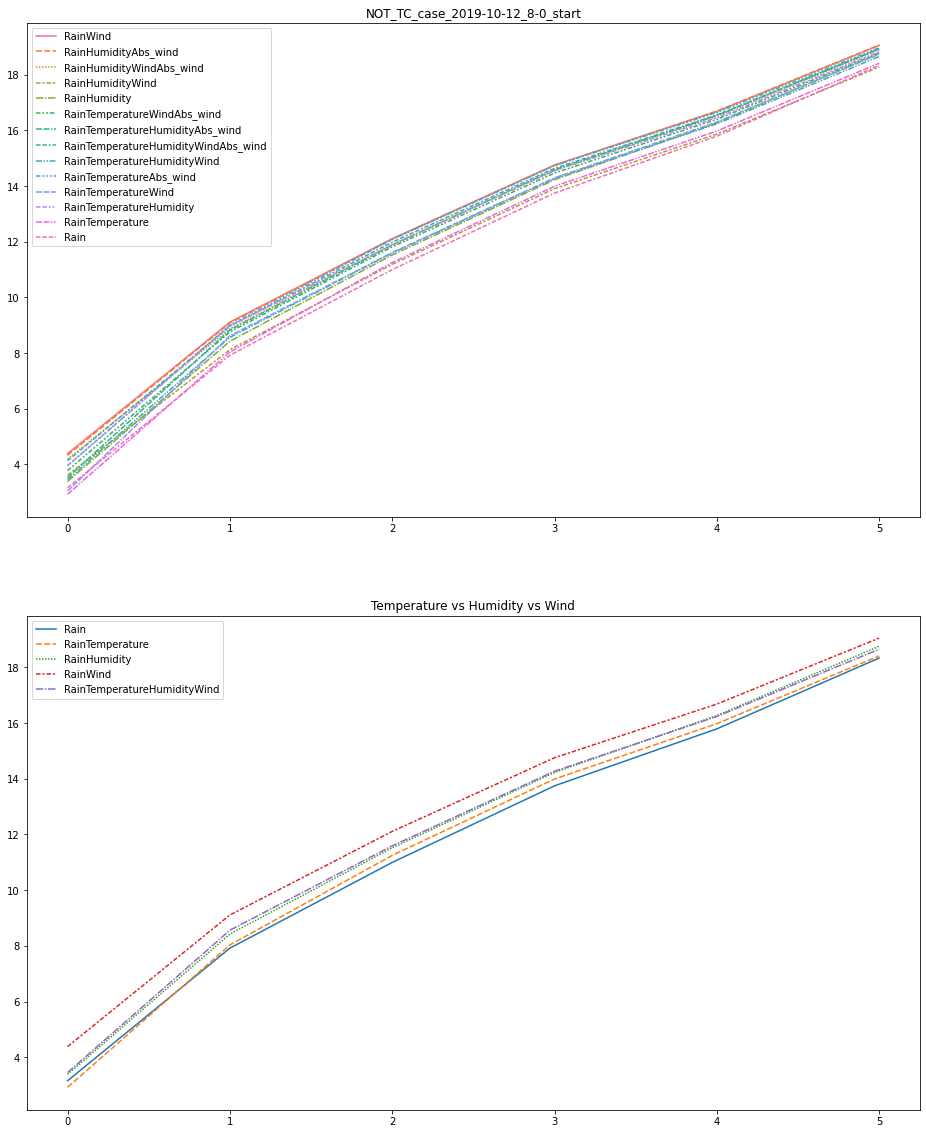

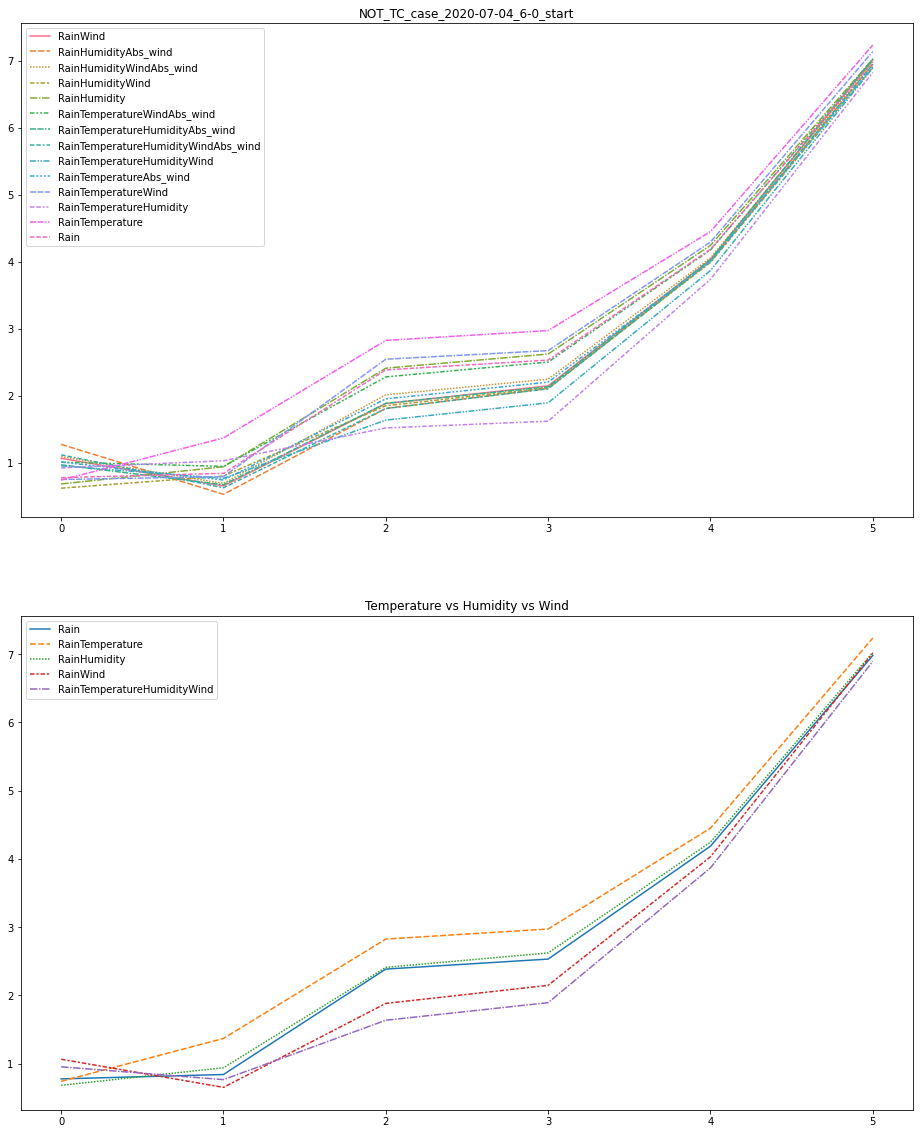

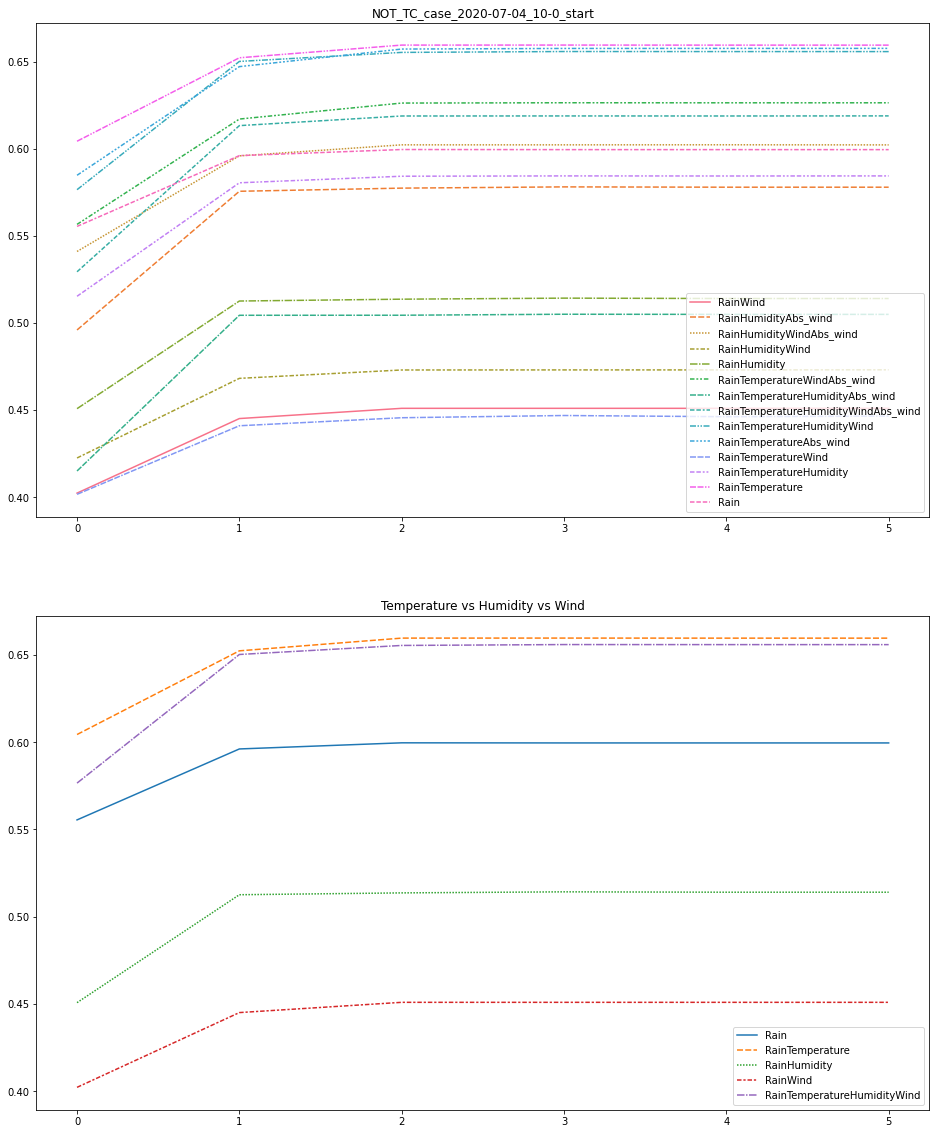

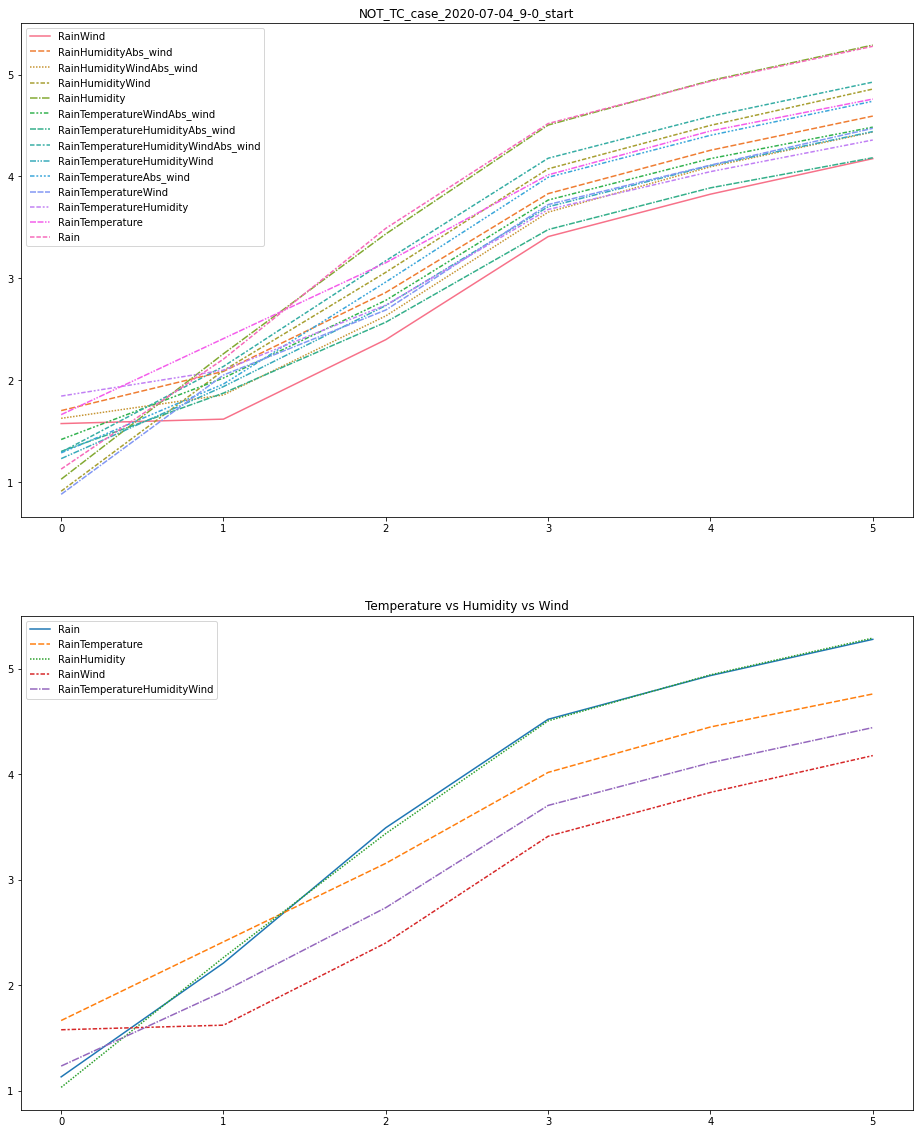

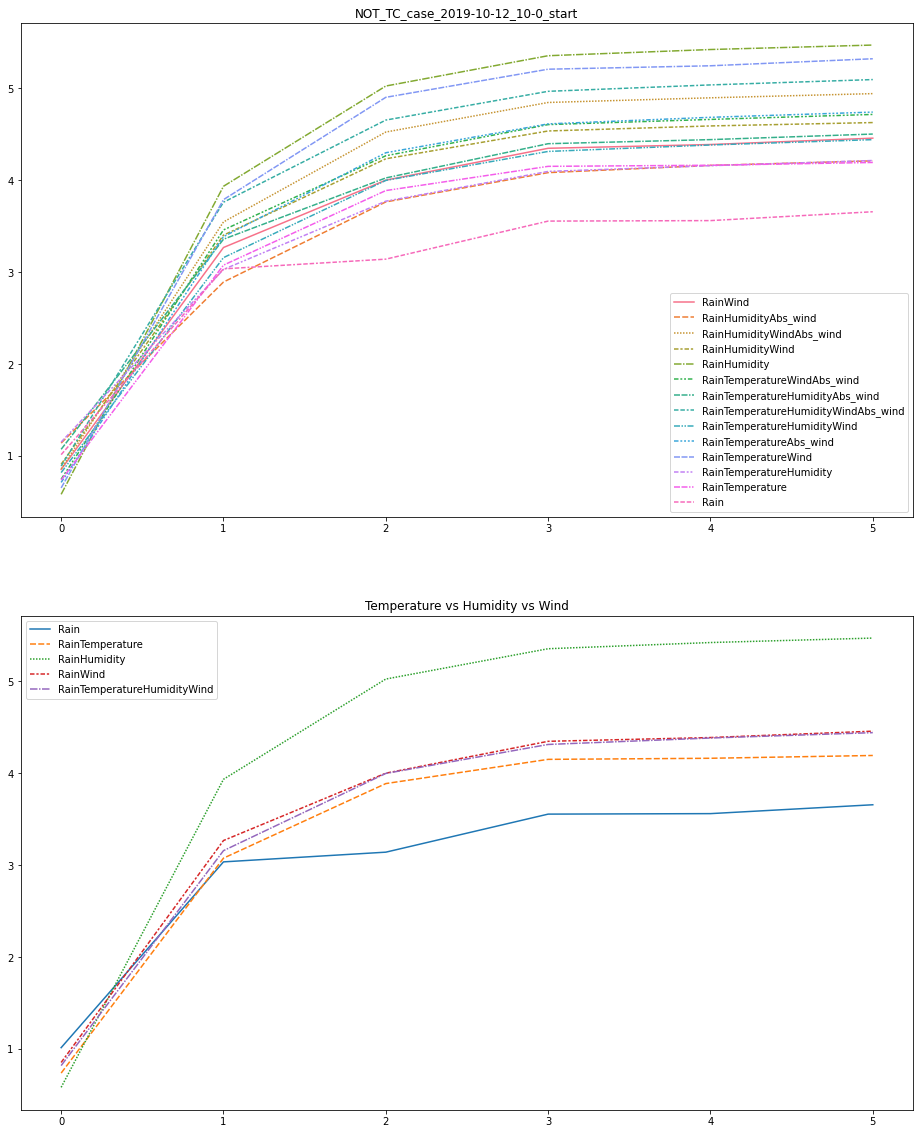

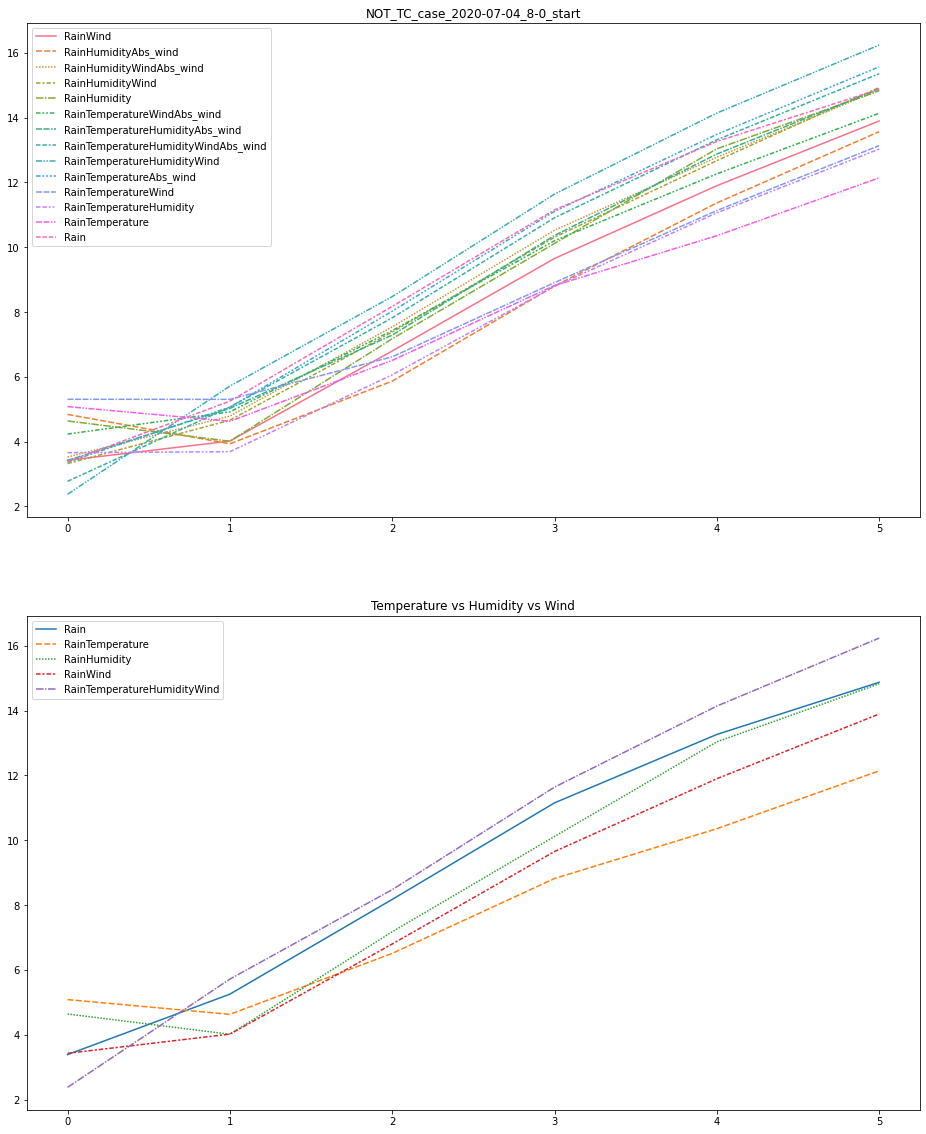

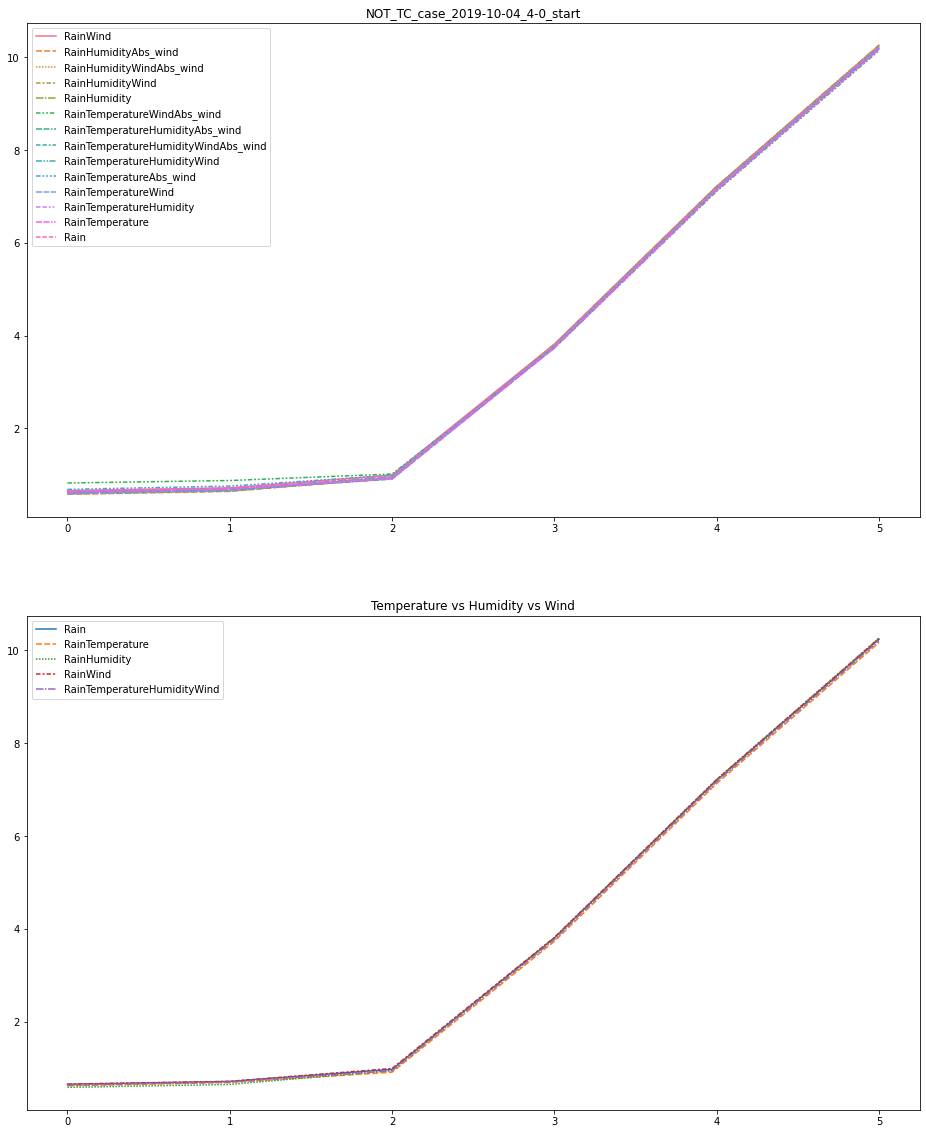

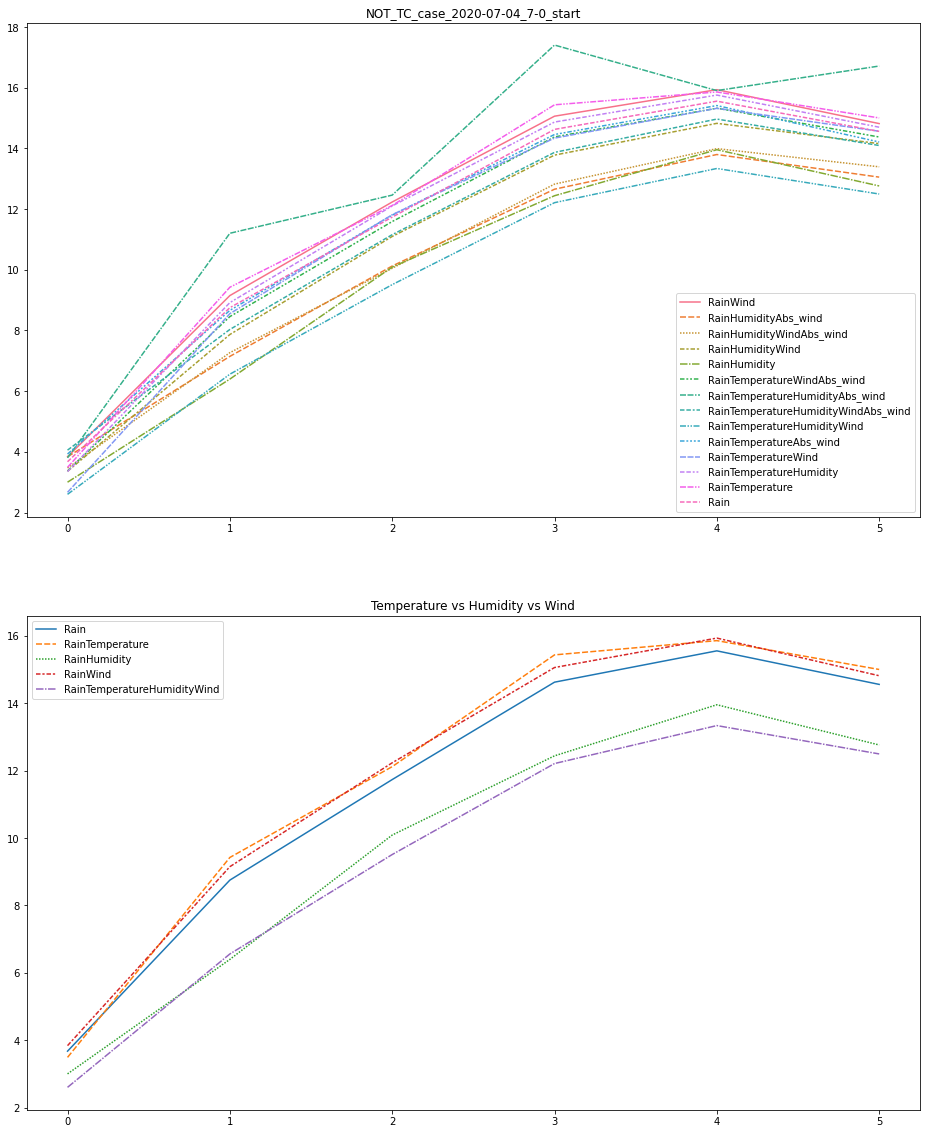

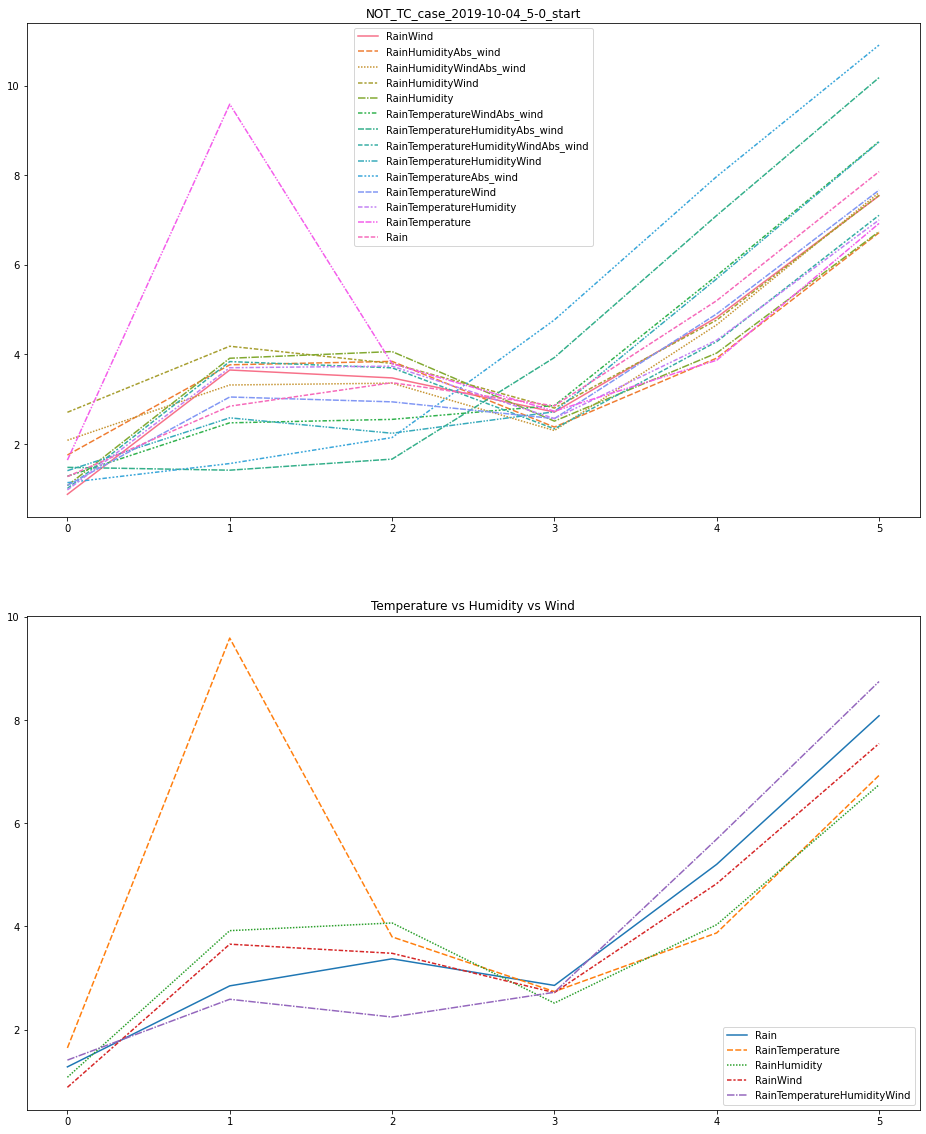

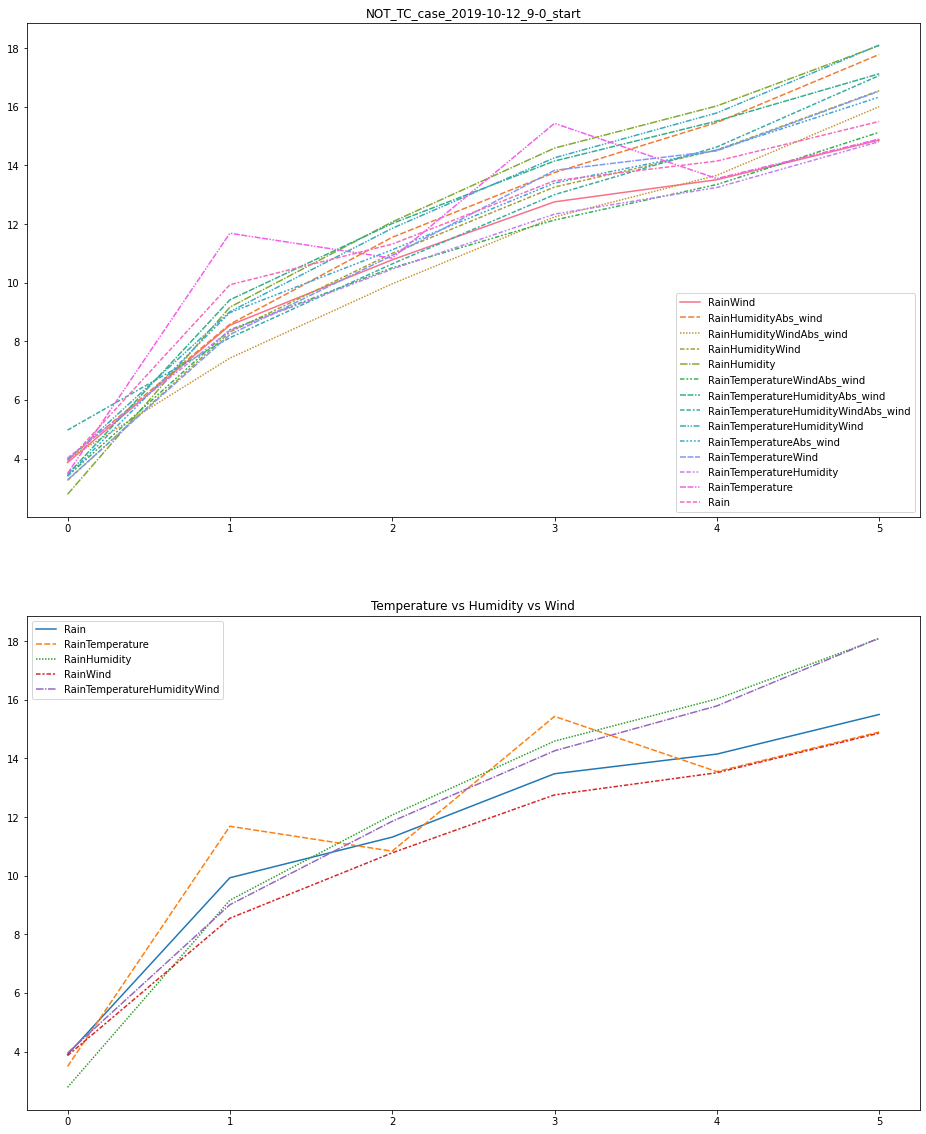

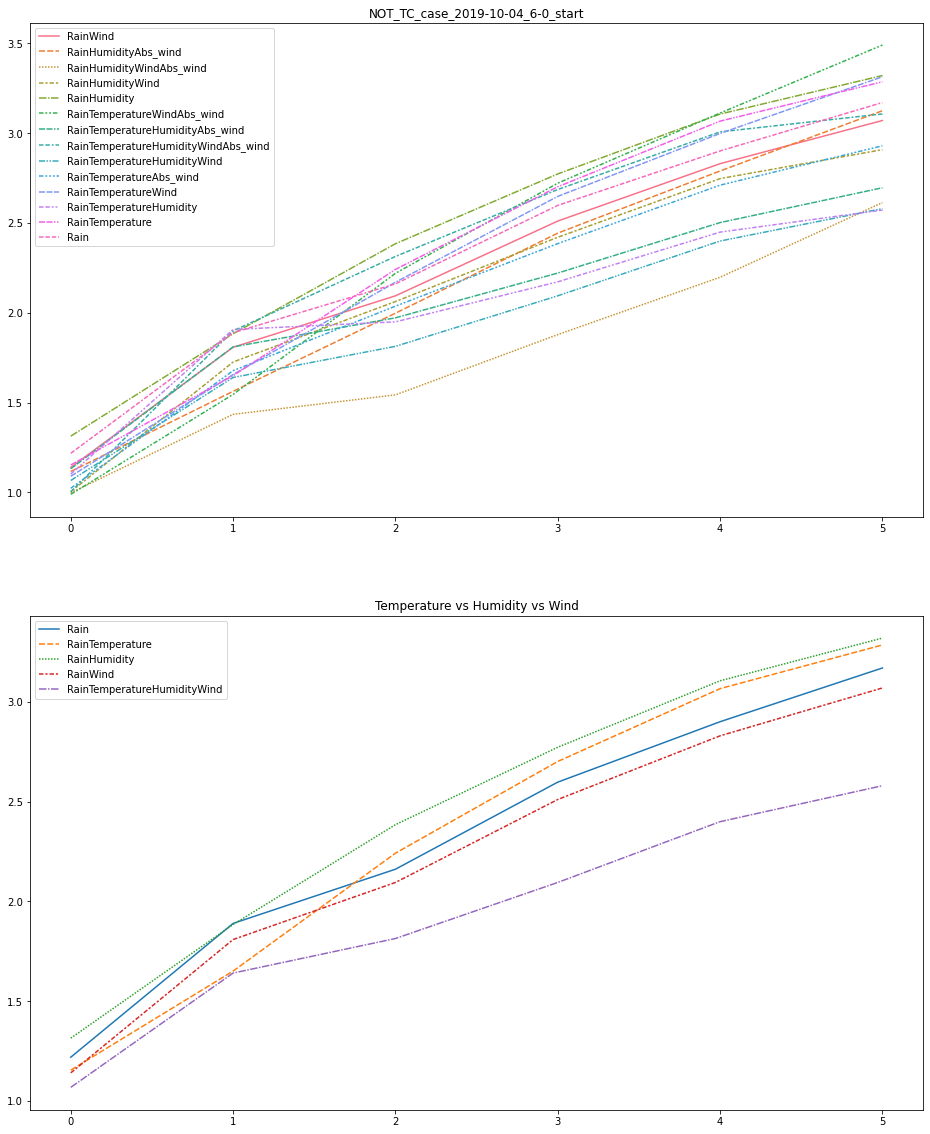

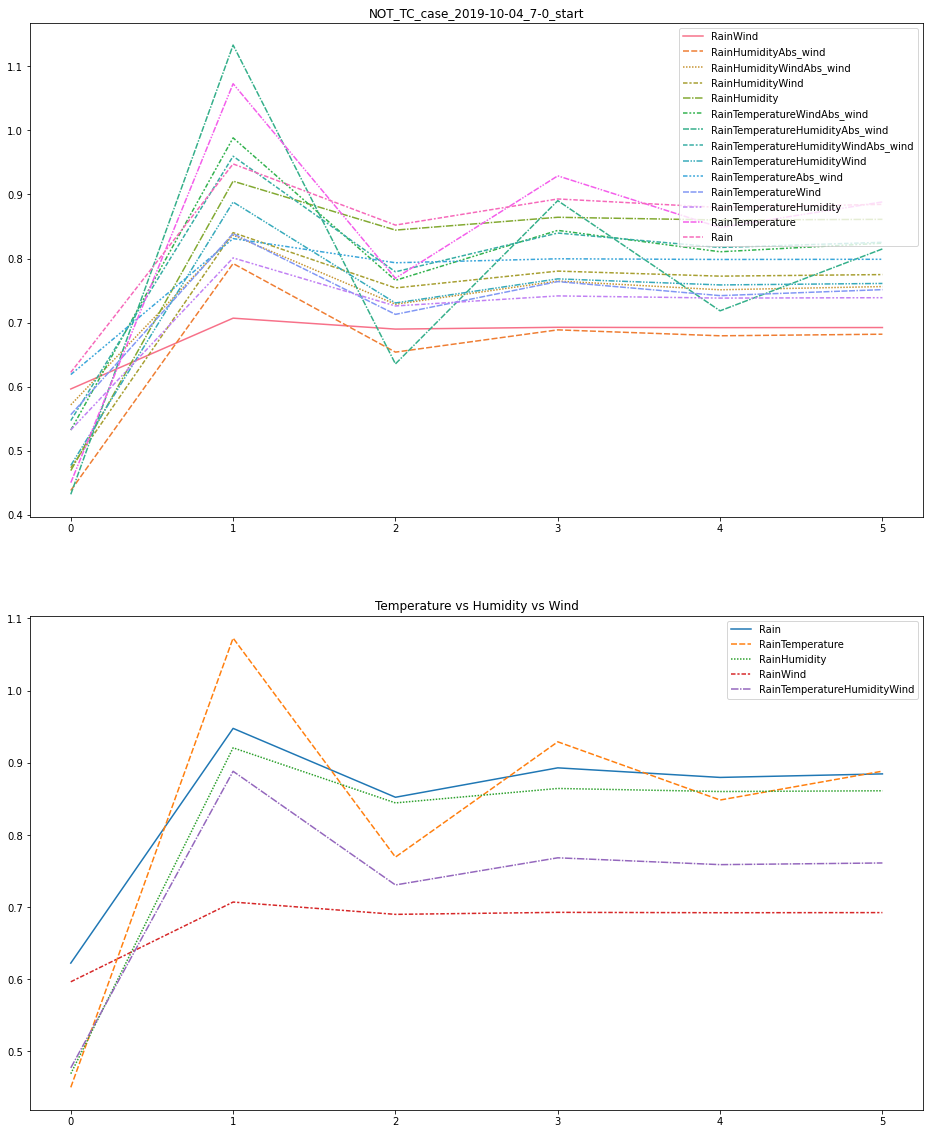

In [23]:
# NOT TC case result

case_names = list(not_tc_case_rmses["Rain"].keys())
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in not_tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    # Visualize
    fig, ax = plt.subplots(2, 1, figsize=(16, 20))
    ax = ax.flatten()
    # Compare with all input parameters
    sns.lineplot(data=df, ax=ax[0])
    ax[0].set_title(case_name)
    
    # Select target parameters
    target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
    sns.lineplot(data=df[target_cols], ax=ax[1])
    ax[1].set_title("Temperature vs Humidity vs Wind")
    
    plt.savefig(f"./minmax_img/{case_name}.png")
#     # Compare with temperature
#     ## Temperature
#     hue_columns = [i for i in df.columns if "Temperature" in i]
#     other_columns = [i for i in df.columns if "Temperature" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[1], x=df.index, y=col, color="blue")
#     ax[1].set_title("It includes temperature (orange) or not (blue)")
#     ## Humidity
#     hue_columns = [i for i in df.columns if "Humidity" in i]
#     other_columns = [i for i in df.columns if "Humidity" not in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[2], x=df.index, y=col, color="blue")
#     ax[2].set_title("It includes humidity (orange) or not (blue)")
    
#     ## Wind (Wind & Abs_wind)
#     hue_columns = [i for i in df.columns if "Wind" in i or "Abs_wind" in i]
#     other_columns = [i for i in df.columns if "Wind" not in i or "Abs_wind" in i]
    
#     for col in hue_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="orange")
#     for col in other_columns:
#         sns.lineplot(data=df, ax=ax[3], x=df.index, y=col, color="blue")
#     ax[3].set_title("It includes wind (orange) or not (blue)")
    
    plt.show()
    plt.close()

RainWind  RainHumidityAbs_wind  RainHumidityWindAbs_wind  \
0   2.224324              1.667060                  2.329610   
1   4.167465              3.865958                  3.425871   
2   8.147942              8.055193                  8.004727   
3  13.361985             13.399679                 13.299987   
4  16.685685             16.772065                 16.670755   

   RainHumidityWind  RainHumidity  RainTemperatureWindAbs_wind  \
0          2.028896      0.933538                     2.104521   
1          3.926908      2.668715                     4.825257   
2          8.231928      7.554974                     8.531600   
3         13.395608     13.069592                    13.661736   
4         16.793850     16.360746                    17.041884   

   RainTemperatureHumidityAbs_wind  RainTemperatureHumidityWindAbs_wind  \
0                         1.743030                             2.360744   
1                         4.651168                             4.272451   
2                         8.341922                             8.478816   
3                        13.560084                            13.708676   
4                        16.936613                            17.109320   

   RainTemperatureHumidityWind  RainTemperatureAbs_wind  RainTemperatureWind  \
0                     1.788790                 1.404315             1.993954   
1                     2.958775                 4.068553             5.009293   
2                     7.595387                 8.235703             8.613939   
3                    13.052076                13.517207            13.688158   
4                    16.361975                16.897584            17.085684   

   RainTemperatureHumidity  RainTemperature       Rain  
0                 1.968447         1.039068   2.258946  
1                 4.544076         4.063661   4.340155  
2                 8.379926         7.914516   7.980077  
3                13.588047        13.321887  13.104896  
4                16.976394        16.637772  16.377020

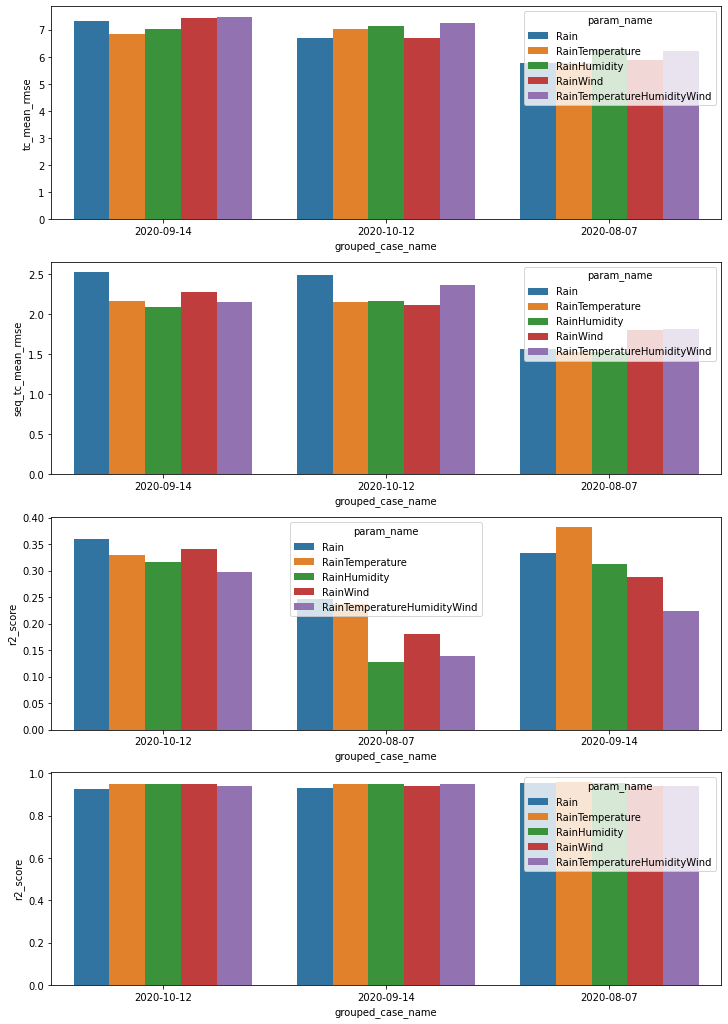

In [25]:
# TC case result
def get_grouped_case_name(case_name: str) -> str:
    if "2020-09-14" in case_name:
        return "2020-09-14"
    elif "2020-08-07" in case_name:
        return "2020-08-07"
    elif "2020-10-12" in case_name:
        return "2020-10-12"
    else:
        return "else"

case_names = list(tc_case_rmses["Rain"].keys())
case_mean_dic = {"tc_mean_rmse": [], "seq_tc_mean_rmse": [], "case_name": [], "param_name": []}
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    seq_df = pd.DataFrame()
    for key, case_result in seq_tc_case_rmses.items():
        target_metrics_dic = case_result[f"Sequential_{case_name}"]
        seq_df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    for col in target_cols: 
        case_mean_dic["tc_mean_rmse"] += [df[col].mean()]
        case_mean_dic["seq_tc_mean_rmse"] += [seq_df[col].mean()]
        case_mean_dic["case_name"] += [case_name]
        case_mean_dic["param_name"] += [col]

rmse_df = pd.DataFrame(case_mean_dic)
rmse_df["grouped_case_name"] = rmse_df["case_name"].apply(get_grouped_case_name)

r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
seq_r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
for col in target_cols:
    target_r2_scores = r2_scores[col]
    for key, val in target_r2_scores.items():
        grouped_case_name = get_grouped_case_name(key)
        if grouped_case_name != "else":
            if "Sequential" in key:
                seq_r2_dic["param_name"].append(col)
                seq_r2_dic["case_name"].append(key)
                seq_r2_dic["grouped_case_name"].append(grouped_case_name)
                seq_r2_dic["r2_score"].append(val)
            else:
                r2_dic["param_name"].append(col)
                r2_dic["case_name"].append(key)
                r2_dic["grouped_case_name"].append(grouped_case_name)
                r2_dic["r2_score"].append(val)

tc_case_r2_df = pd.DataFrame(r2_dic)
seq_tc_case_r2_df = pd.DataFrame(seq_r2_dic)

fig, ax = plt.subplots(4, 1, figsize=(12, 18))
ax = ax.flatten()
sns.barplot(data=rmse_df, x="grouped_case_name", y="tc_mean_rmse", hue="param_name", ci=None, ax=ax[0])
sns.barplot(data=rmse_df, x="grouped_case_name", y="seq_tc_mean_rmse", hue="param_name", ci=None, ax=ax[1])
sns.barplot(data=tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[2])
sns.barplot(data=seq_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[3])
# Use Barplot with grouping

plt.savefig(f"./minmax_img/tc_case_r2_scores.png")
df.head()

In [15]:
tc_case_r2_df

r2_score                   param_name            case_name  \
0      0.359                         Rain  r2_2020-10-12_cases   
1      0.246                         Rain  r2_2020-08-07_cases   
2      0.334                         Rain  r2_2020-09-14_cases   
3      0.329              RainTemperature  r2_2020-10-12_cases   
4      0.237              RainTemperature  r2_2020-08-07_cases   
5      0.382              RainTemperature  r2_2020-09-14_cases   
6      0.316                 RainHumidity  r2_2020-10-12_cases   
7      0.128                 RainHumidity  r2_2020-08-07_cases   
8      0.313                 RainHumidity  r2_2020-09-14_cases   
9      0.340                     RainWind  r2_2020-10-12_cases   
10     0.181                     RainWind  r2_2020-08-07_cases   
11     0.287                     RainWind  r2_2020-09-14_cases   
12     0.297  RainTemperatureHumidityWind  r2_2020-10-12_cases   
13     0.138  RainTemperatureHumidityWind  r2_2020-08-07_cases   
14     0.224  RainTemperatureHumidityWind  r2_2020-09-14_cases   

   grouped_case_name  
0         2020-10-12  
1         2020-08-07  
2         2020-09-14  
3         2020-10-12  
4         2020-08-07  
5         2020-09-14  
6         2020-10-12  
7         2020-08-07  
8         2020-09-14  
9         2020-10-12  
10        2020-08-07  
11        2020-09-14  
12        2020-10-12  
13        2020-08-07  
14        2020-09-14

RainWind  RainHumidityAbs_wind  RainHumidityWindAbs_wind  RainHumidityWind  \
0  0.596455              0.437988                  0.571702          0.473385   
1  0.706961              0.792272                  0.836547          0.840454   
2  0.689905              0.653960                  0.728732          0.754155   
3  0.692702              0.688696                  0.764879          0.780404   
4  0.692187              0.679463                  0.751262          0.772548   

   RainHumidity  RainTemperatureWindAbs_wind  RainTemperatureHumidityAbs_wind  \
0      0.469063                     0.532291                         0.432051   
1      0.920781                     0.988361                         1.133187   
2      0.844402                     0.765981                         0.635618   
3      0.864417                     0.843972                         0.890380   
4      0.860171                     0.810568                         0.718420   

   RainTemperatureHumidityWindAbs_wind  RainTemperatureHumidityWind  \
0                             0.547103                     0.477096   
1                             0.959703                     0.888200   
2                             0.779306                     0.730675   
3                             0.839809                     0.768292   
4                             0.817293                     0.758832   

   RainTemperatureAbs_wind  RainTemperatureWind  RainTemperatureHumidity  \
0                 0.618935             0.556273                 0.532578   
1                 0.831180             0.838903                 0.801014   
2                 0.793437             0.712893                 0.726014   
3                 0.799636             0.764028                 0.741705   
4                 0.798582             0.742155                 0.738312   

   RainTemperature      Rain  
0         0.450161  0.622356  
1         1.072846  0.947678  
2         0.769297  0.852226  
3         0.929075  0.892984  
4         0.848376  0.879712

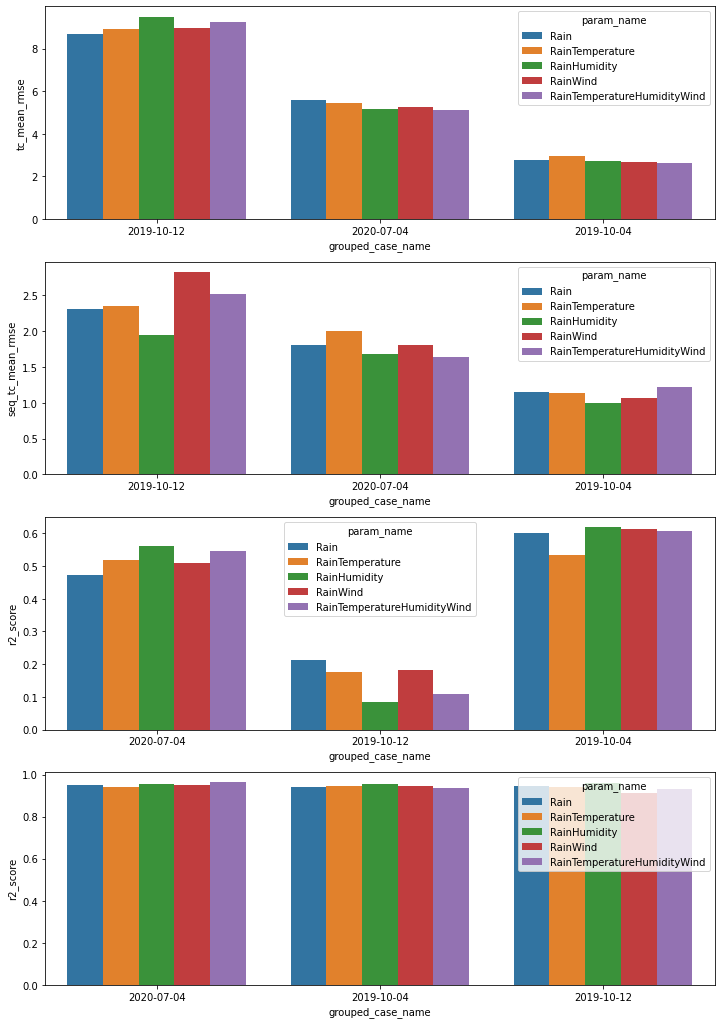

In [26]:
# NOT TC case result
def get_grouped_case_name(case_name: str) -> str:
    if "2019-10-04" in case_name:
        return "2019-10-04"
    elif "2020-07-04" in case_name:
        return "2020-07-04"
    elif "2019-10-12" in case_name:
        return "2019-10-12"
    else:
        return "else"

case_names = list(not_tc_case_rmses["Rain"].keys())
case_mean_dic = {"tc_mean_rmse": [], "seq_tc_mean_rmse": [], "case_name": [], "param_name": []}
target_cols = ["Rain", "RainTemperature", "RainHumidity", "RainWind", "RainTemperatureHumidityWind"]
for case_name in case_names:
    df = pd.DataFrame()
    for key, case_result in not_tc_case_rmses.items():
        target_metrics_dic = case_result[case_name]
        df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    seq_df = pd.DataFrame()
    for key, case_result in seq_not_tc_case_rmses.items():
        target_metrics_dic = case_result[f"Sequential_{case_name}"]
        seq_df[key] = [v for k, v in sorted(target_metrics_dic.items(), key=lambda item: item[0])]
    
    for col in target_cols: 
        case_mean_dic["tc_mean_rmse"] += [df[col].mean()]
        case_mean_dic["seq_tc_mean_rmse"] += [seq_df[col].mean()]
        case_mean_dic["case_name"] += [case_name]
        case_mean_dic["param_name"] += [col]

rmse_df = pd.DataFrame(case_mean_dic)
rmse_df["grouped_case_name"] = rmse_df["case_name"].apply(get_grouped_case_name)

r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
seq_r2_dic = {"r2_score": [], "param_name": [], "case_name": [], "grouped_case_name": []}
for col in target_cols:
    target_r2_scores = r2_scores[col]
    for key, val in target_r2_scores.items():
        grouped_case_name = get_grouped_case_name(key)
        if grouped_case_name != "else":
            if "Sequential" in key:
                seq_r2_dic["param_name"].append(col)
                seq_r2_dic["case_name"].append(key)
                seq_r2_dic["grouped_case_name"].append(grouped_case_name)
                seq_r2_dic["r2_score"].append(val)
            else:
                r2_dic["param_name"].append(col)
                r2_dic["case_name"].append(key)
                r2_dic["grouped_case_name"].append(grouped_case_name)
                r2_dic["r2_score"].append(val)

not_tc_case_r2_df = pd.DataFrame(r2_dic)
seq_tc_case_r2_df = pd.DataFrame(seq_r2_dic)

fig, ax = plt.subplots(4, 1, figsize=(12, 18))
ax = ax.flatten()
sns.barplot(data=rmse_df, x="grouped_case_name", y="tc_mean_rmse", hue="param_name", ci=None, ax=ax[0])
sns.barplot(data=rmse_df, x="grouped_case_name", y="seq_tc_mean_rmse", hue="param_name", ci=None, ax=ax[1])
sns.barplot(data=not_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[2])
sns.barplot(data=seq_tc_case_r2_df, x="grouped_case_name", y="r2_score", hue="param_name", ci=None, ax=ax[3])
# Use Barplot with grouping

plt.savefig(f"./minmax_img/not_tc_case_r2_scores.png")
df.head()